<a href="https://colab.research.google.com/github/FrancescoRosi01/Tesi/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import tensorflow as tf
from tensorflow import keras
from google.colab import drive
import matplotlib.pyplot as plt
from pathlib import Path
import json
import numpy as np
import re
from sklearn.model_selection import train_test_split

In [13]:
# clona la repo con i dataset
# i dataset sono in ./Tesi/datasets/
# il primo dataset è ./Tesi/datasets/ds
!git clone https://github.com/FrancescoRosi01/Tesi.git

fatal: destination path 'Tesi' already exists and is not an empty directory.


In [14]:
def load_and_process_image(path, label):
    """ restituisce il tensore 3d (l'immagine) e la label associata al path che prende in input"""
    img_raw = tf.io.read_file(path)
    img = tf.io.decode_png(img_raw, channels=3)
    img = tf.image.resize(img, (224,224))
    # normalizzare
    img = img / 255.0
    return img, label

def load_ds(ds_path : Path):
    """ restituisce i dataset di training, validation e test"""
    imgs_path = ds_path / 'images'
    labels_path = ds_path / 'labels' / 'labels.json'
    with open(labels_path, 'r') as f:
        labels = json.load(f)
        labels = np.array(list(labels.values()))
        labels = labels.astype(np.float32)
    regex = re.compile(r"img_(\d+)\.png")
    # imgs_path è una lista ordinata di path delle immagini.
    imgs_path = sorted(
        map(lambda x:str(x),imgs_path.glob('img_*.png')),
        key=lambda x: int(regex.search(x).group(1))
        )
    train_paths, test_paths, train_labels, test_labels = train_test_split(imgs_path, labels, test_size=0.2, random_state=1)
    train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.25, random_state=1)
    # train -> 60%, val -> 20%, test -> 20%
    train_ds = tf.data.Dataset.from_tensor_slices((train_paths,train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_paths,val_labels))
    test_ds = tf.data.Dataset.from_tensor_slices((test_paths,test_labels))
    BATCH_SZ = 32
    # load_and_process_image restituisce il tensore 3d (l'immagine) associata al path che prende in input
    train_ds = train_ds.map(load_and_process_image, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.map(load_and_process_image, num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_ds.map(load_and_process_image, num_parallel_calls=tf.data.AUTOTUNE)
    # Shuffle
    train_ds = train_ds.shuffle(buffer_size=1000)
    val_ds = val_ds.shuffle(buffer_size=1000)
    # Batch
    train_ds = train_ds.batch(BATCH_SZ)
    val_ds = val_ds.batch(BATCH_SZ)
    test_ds = test_ds.batch(BATCH_SZ)
    train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.prefetch(buffer_size= tf.data.AUTOTUNE)
    return train_ds,val_ds,test_ds

In [15]:
train,val,test = load_ds(Path("Tesi/datasets/ds"))

In [16]:
for images, labels in train.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    print(f"Sample label: {labels[0]}")

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)
Sample label: 0.13333334028720856


In [17]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(224,224,3)),

    keras.layers.Conv2D(32, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu',kernel_initializer="he_normal"),
    keras.layers.Dropout(0.5),
    # tanh come attivazione finale perchè resituisce valori tra -1 e 1
    keras.layers.Dense(1, activation='tanh')
    ])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae'],
)

In [18]:
# su CPU Colab il training per il primo ds dura circa 5 min
history = model.fit(
    train,
    epochs = 10,
    validation_data = val,
    callbacks=[keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)]
    )


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - loss: 0.3701 - mae: 0.4761 - val_loss: 0.0403 - val_mae: 0.1544
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - loss: 0.0496 - mae: 0.1716 - val_loss: 0.0114 - val_mae: 0.0822
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 0.0257 - mae: 0.1224 - val_loss: 0.0072 - val_mae: 0.0682
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - loss: 0.0156 - mae: 0.0956 - val_loss: 0.0036 - val_mae: 0.0488
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 0.0131 - mae: 0.0852 - val_loss: 0.0046 - val_mae: 0.0561
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - loss: 0.0110 - mae: 0.0786 - val_loss: 0.0024 - val_mae: 0.0392
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - loss: 0.0099 - mae: 0.0743 - val_loss: 0.0029 - val_mae: 0.0431
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - loss: 0.0100 - mae: 0.0737 - val_loss: 0.0024 - val_mae: 0.0365
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - loss: 0.0080 - mae: 

In [19]:
model.evaluate(test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step - loss: 0.0020 - mae: 0.0333


[0.0018747142748907208, 0.032710932195186615]

QUI alcune funzioni prese dal notebook [TODO.ipynb](https://tilburgsciencehub.com/topics/automation/replicability/cloud-computing/colab-github/) per generare immagini e testare il modello

In [27]:
import cv2

black = (0,0,0)
white = (255,250,255)
blue = (173,216,230)
orange = (255,165,0)

def gen_image(H,W,angle,offset,background_color,line_color,line_width=30):
    dims = (H,W,3)
    img = np.full(dims, background_color, dtype=np.uint8)
    rad = angle * np.pi / 180 # convertiamo in radianti
    alfa = np.tan(rad) # otteniamo il coeff. angolare della linea
    y2 = int(alfa * (H // 2)) # e l'offset da sommare o sottrarre a center_cols
    center_rows = H // 2
    center_cols = W // 2
    cv2.line(img,(center_cols - y2 + offset,0),(center_cols + y2 + offset,H),line_color,line_width,lineType=cv2.LINE_AA)
    return img
def apply_effects(img):
    # applichiamo il filtro gaussiano
    img = img.astype(np.float32)
    img = cv2.GaussianBlur(img,(5,5),0)
    # aggiungiamo rumore gaussiano
    img = img + np.random.normal(0, 13, img.shape)
    img = img.clip(0,255).astype(np.uint8)
    return img
def preprocess_for_model(img):
    """abbiamo bisogno di questa funzione perchè opencv restituisce dei tensori
      BGR, di tipo uint8. Il modello prende in input delle immagini RGB di tipo
      float32"""
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (224,224))
    img_normalized = img_resized.astype(np.float32) / 255.0
    # dobbiamo aggiungere una dimensione (quella di batch) al tensore 3d
    img_batch = np.expand_dims(img_normalized, axis=0)
    return img_batch

array([[[ 0, 16, 12],
        [ 0,  0,  0],
        [ 0,  0,  6],
        ...,
        [ 0,  7,  1],
        [ 0,  1,  6],
        [ 0,  6, 11]],

       [[ 1, 11,  0],
        [ 0,  6,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  4,  0],
        [ 0,  0,  1],
        [16, 17,  6]],

       [[ 8,  0,  0],
        [ 0, 27, 25],
        [ 0,  4,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  2],
        [ 0,  0,  0]],

       ...,

       [[ 0,  9,  0],
        [ 0,  0, 13],
        [ 0, 15,  0],
        ...,
        [14, 14, 21],
        [ 0,  0,  0],
        [ 5,  0,  0]],

       [[ 0,  1,  6],
        [14, 18,  0],
        [ 0,  0, 26],
        ...,
        [10,  0,  0],
        [ 8, 27,  4],
        [ 0, 10,  2]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0, 22,  7],
        ...,
        [ 0,  6,  0],
        [ 0,  8,  0],
        [ 0,  6,  0]]], dtype=uint8)
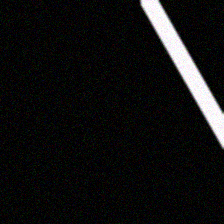

In [78]:
apply_effects(gen_image(224,224,30,100,black,white,15))

In [75]:
angle = 30 # modificare l'offset per vedere il funzionamento
offset = 100 # modificare l'offset per vedere il funzionamento
input = preprocess_for_model(apply_effects(gen_image(224,224,angle,offset,black,white,15)))
print(f'Angolo (inferito) : {model(input).numpy().item() * 45}')
print(f'Angolo (vero) : {angle}')

Angolo (inferito) : -1.631325390189886
Angolo (vero) : 30


Si vede che il modello performa bene quando


1.   le immagini hanno sfondo nero e linea bianca
2.   l'offset è nel range -100, 100

il punto 1 è abbastanza comprensibile dato che il modello è stato addestrato solo su immagini con background nero e linea bianca.



In [52]:
input = preprocess_for_model(apply_effects(gen_image(224,224,angle,offset,blue,orange,15)))
print(f'Angolo (inferito) : {model(input).numpy().item() * 45}')
print(f'Angolo (vero) : {angle}')

Angolo (inferito) : -0.5825219443067908
Angolo (vero) : 15
